<h1>I. Import library and load dataset

In [2]:
import numpy as np 

import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torchvision.models import resnet50

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt 

import optuna

import warnings
warnings.filterwarnings('ignore')

This way of tranforming data credit to notebook [CIFAR10 Custom+Resnet CNN Pytorch (> 97% Acc)](https://www.kaggle.com/code/ayushnitb/cifar10-custom-resnet-cnn-pytorch-97-acc#1.-Data-Preparation) in Kaggle. However, when using this transformation in all models (DNN, tuned DNN, CNN), there is a noted decrease in accuracy.

In [2]:
IMAGE_SIZE = 32

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
                                     transforms.RandomRotation(20),
                                     transforms.RandomHorizontalFlip(0.1),
                                     transforms.ColorJitter(brightness = 0.1,
                                                            contrast = 0.1, 
                                                            saturation = 0.1), 
                                     transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std), 
                                     transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)])


composed_test = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

train_labels = [label for _, label in trainset]

Files already downloaded and verified
Files already downloaded and verified


In this case, a simple transformation is much better.

In [3]:
mean, std = [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

train_labels = [label for _, label in trainset]

for images, labels in trainloader:
    print("Batch of images shape:", images.shape)
    break 

Files already downloaded and verified
Files already downloaded and verified
Batch of images shape: torch.Size([128, 3, 32, 32])


<h1>II. EDA

EDA part is referenced from notebook [CIFAR10 Custom+Resnet CNN Pytorch (> 97% Acc)](https://www.kaggle.com/code/ayushnitb/cifar10-custom-resnet-cnn-pytorch-97-acc#1.-Data-Preparation) on Kaggle.


In [4]:
def show_data(img):
    try:
        plt.imshow(img[0])
    except Exception as e:
        print(e)
    print(img[0].shape, img[0].permute(1,2,0).shape)
    plt.imshow(img[0].permute(1,2,0))
    plt.title('y = '+ str(img[1]))
    plt.show()

def im_convert(tensor):
    img = tensor.cpu().clone().detach().numpy() 
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1)
    return img

A picture in dataset should look like this:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


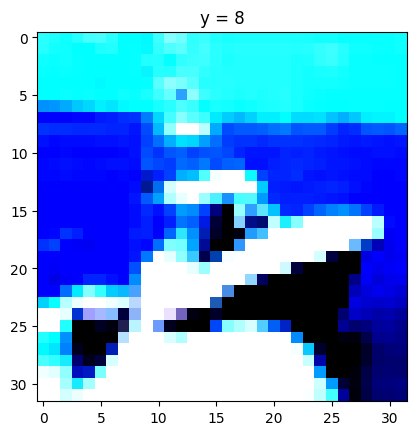

In [5]:
show_data(trainset[8])

Pictures of each classes should looks like this:

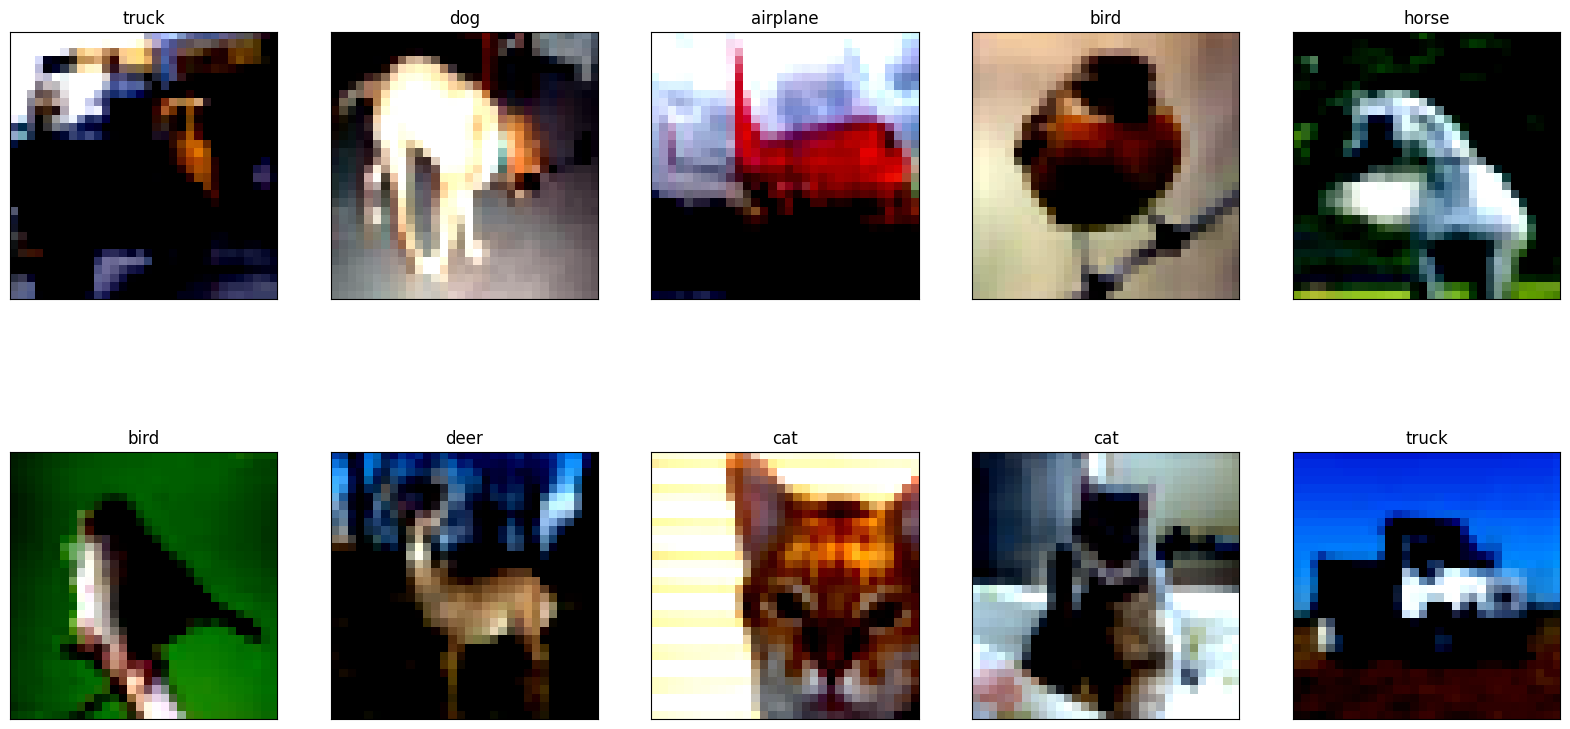

In [6]:
classes = ('airplane', 
           'automobile', 
           'bird',
           'cat',
           'deer',
           'dog', 
           'frog', 
           'horse', 
           'ship',
           'truck')

data_iterable = iter(trainloader)  
images, labels = next(data_iterable) 
fig = plt.figure(figsize=(20, 10)) 

for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])

    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

<h1> III. Model

<h2>1. DNN

In [7]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*32*32, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.model(x)

model = DNN()

epochs = 10 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)

for i in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()


        running_loss += loss.item()

    print(f"Epoch {i+1}/{epochs}, Loss: {running_loss / len(trainloader):.4f}")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predict = torch.max( outputs,1)

        all_preds.extend(predict.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds) 
print(f"Test accuracy Score: {accuracy:.4f}")

Epoch 1/10, Loss: 1.8683
Epoch 2/10, Loss: 1.6673
Epoch 3/10, Loss: 1.5963
Epoch 4/10, Loss: 1.5463
Epoch 5/10, Loss: 1.5089
Epoch 6/10, Loss: 1.4826
Epoch 7/10, Loss: 1.4582
Epoch 8/10, Loss: 1.4339
Epoch 9/10, Loss: 1.4162
Epoch 10/10, Loss: 1.4012
Test accuracy Score: 0.5179


At first attempt with a simple three fully-connected layers DNN model, the accuracy score is low, at 0.5179.

<h2>2. CNN

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))    
        x = x.view(-1, 32 * 8 * 8)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model = CNN()
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for i in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()


        running_loss += loss.item()

    print(f"Epoch {i+1}/{epochs}, Loss: {running_loss / len(trainloader):.4f}")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predict = torch.max( outputs,1)

        all_preds.extend(predict.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds) 
print(f"Test Accuracy Score: {accuracy:.4f}")

Epoch 1/10, Loss: 1.4370
Epoch 2/10, Loss: 1.1101
Epoch 3/10, Loss: 0.9772
Epoch 4/10, Loss: 0.8977
Epoch 5/10, Loss: 0.8303
Epoch 6/10, Loss: 0.7795
Epoch 7/10, Loss: 0.7354
Epoch 8/10, Loss: 0.6940
Epoch 9/10, Loss: 0.6566
Epoch 10/10, Loss: 0.6190
Test Accuracy Score: 0.7252


By adding two more convolution layers and max-pooling layers, the accuracy increased to 0.7252. However, it is still considered a low accuracy score.

<h3>2.1. Hyperparameters tuning 

In [9]:
class CNN(nn.Module):
    def __init__(self, dropout_rate):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x) 
        x = self.fc2(x)
        return x

def objective(trial):
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_int("batch_size", 16, 128, step=16)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
    
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=64, shuffle=False)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = CNN(dropout_rate).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(10): 
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f"Accuracy: {trial.value:.4f}")
print("Hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-12-25 16:12:16,037] A new study created in memory with name: no-name-110654c1-c334-46a6-a0fd-ff7b75e93e9a
[I 2024-12-25 16:17:10,111] Trial 0 finished with value: 0.7153 and parameters: {'weight_decay': 0.0006455633708728618, 'learning_rate': 0.0028101218214445596, 'batch_size': 64, 'dropout_rate': 0.10862603365529583}. Best is trial 0 with value: 0.7153.
[I 2024-12-25 16:21:52,409] Trial 1 finished with value: 0.7032 and parameters: {'weight_decay': 0.0009759708652930885, 'learning_rate': 0.0019898298591795554, 'batch_size': 112, 'dropout_rate': 0.48456241790231613}. Best is trial 0 with value: 0.7153.
[I 2024-12-25 16:28:32,756] Trial 2 finished with value: 0.6996 and parameters: {'weight_decay': 1.6835505701204708e-05, 'learning_rate': 0.0001899608773789341, 'batch_size': 16, 'dropout_rate': 0.40934380931251113}. Best is trial 0 with value: 0.7153.
[I 2024-12-25 16:33:15,918] Trial 3 finished with value: 0.7204 and parameters: {'weight_decay': 0.0009171383365606337, 'learnin

Best trial:
Accuracy: 0.7338
Hyperparameters:
    weight_decay: 6.696242935448574e-05
    learning_rate: 0.0010884907829771342
    batch_size: 48
    dropout_rate: 0.20789850398554383


Accuracy: 0.7338
Hyperparameters:
    weight_decay: 6.696242935448574e-05
    learning_rate: 0.0010884907829771342
    batch_size: 48
    dropout_rate: 0.20789850398554383

After tuning for nine hyperparameters—learning rate, batch size, dropout rate, number of layers, number of filters, kernel sizes, pool size, number of neurons, and weight decay—the best hyperparameters were fitted to the models. This resulted in a significant improvement, with the accuracy score increasing to 0.7338.

Optuna is the hyperparameter optimization framework used to find the best hyperparameters.

<h3>2.2. Fine tuning

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 10) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001, weight_decay=0.0001)

epochs = 10
for epoch in range(epochs):
    resnet50.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(trainloader):.4f}")

resnet50.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predict = torch.max(outputs, 1)
        all_preds.extend(predict.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy Score: {accuracy:.4f}")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 0.7974


Due to the costly computation, resnet 50 final result is only documented by text at 0.8348.

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

def get_model(num_classes=10, dropout_rate=0.5):
    model = resnet50(pretrained=True)
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(model.fc.in_features, num_classes)
    )
    return model

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    return total_loss / len(train_loader), correct / len(train_loader.dataset)

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()

    return total_loss / len(test_loader), correct / len(test_loader.dataset)

def objective(trial):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
    step_size = trial.suggest_int('step_size', 5, 15)
    gamma = trial.suggest_uniform('gamma', 0.1, 0.9)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2)

    model = get_model(dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    best_accuracy = 0
    for epoch in range(20): 
        train(model, train_loader, optimizer, criterion, device)
        _, accuracy = evaluate(model, test_loader, criterion, device)
        scheduler.step()

        best_accuracy = max(best_accuracy, accuracy)
        trial.report(accuracy, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best Trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

'lr': 0.0003180568082587095, 'weight_decay': 3.234913499805482e-05, 'step_size': 10, 'gamma': 0.2624534077375096, 'batch_size': 64, 'dropout_rate': 0.31073682148057613}. Best is trial 1 with value: 0.8679.

<h1>IV. Models results comparision:

In summary, the accuracy score of each model is: 
- DNN: 0.5179
- CNN: 0.7252
- CNN tunned: 0.7338
- Resnet50: 0.8348
- Resnet50 fine_tuned: 0.8679

